# Yield Estimation for Orchards - Vision Transformer Vs Well Established Approaches

## Introduction

## Related Work

## Approach

## The Dataset
- acfr-fruit-dataset

In [49]:
import os.path

import pandas as pd
from os import listdir
from tqdm import tqdm
def build_annotation_dataframe(path: str) -> pd.DataFrame:
    annotations = pd.DataFrame()
    for i, annotation in enumerate(tqdm(listdir(path))):
        part = pd.read_csv(os.path.join(path, annotation))
        part["picture_id"] = [annotation[:-4] for i in range(len(part))]
        part["picture_id"] = part["picture_id"].astype("string")
        if i == 0:
            annotations = part
            continue
        annotations = pd.concat([annotations,part])
    annotations.reset_index(inplace=True, drop=True)
    return annotations

In [50]:
dataset = {
    "almonds": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/almonds/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    },
    "apples": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/apples/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    },
    "mangoes": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/mangoes/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    }
}

100%|████████████████████████████████████████████████████████████████| 1964/1964 [00:06<00:00, 311.11it/s]


In [ ]:
dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]

In [51]:
print(f" Pictures without Annotations for Almonds: {len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/'))}")
print(f" Pictures without Annotations for Apples: {len(listdir('datasets/acfr-fruit-dataset/apples/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/apples/annotations/'))}")
print(f" Pictures without Annotations for Mangoes: {len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/'))}")

 Pictures without Annotations for Almonds: 48, total number of pictures: 620
 Pictures without Annotations for Apples: 548, total number of pictures: 1120
 Pictures without Annotations for Mangoes: 1392, total number of pictures: 1964


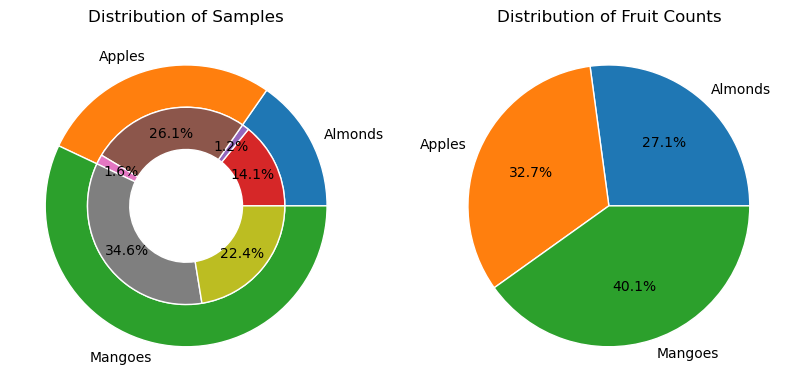

In [52]:
import matplotlib.pyplot as plt
import numpy as np
x_pictures = np.array([
    [len(dataset["almonds"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/')) - len(dataset["almonds"]["global_df"].picture_id.unique())],
    [len(dataset["apples"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/apples/annotations/')) - len(dataset["apples"]["global_df"].picture_id.unique())],
    [len(dataset["mangoes"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/')) - len(dataset["apples"]["global_df"].picture_id.unique())]
])
x_fruits = [len(dataset["almonds"]["global_df"]), len(dataset["apples"]["global_df"]), len(dataset["mangoes"]["global_df"])]
labels = ["Almonds", "Apples", "Mangoes"]
size = 0.3
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pie(x_pictures.sum(axis=1), radius=1, labels=labels, wedgeprops=dict(width=0.3, edgecolor='w'))
ax[0].pie(x_pictures.flatten(), radius=1-size, autopct='%1.1f%%',wedgeprops=dict(width=0.3, edgecolor='w'), pctdistance=0.75)
ax[0].set_title("Distribution of Samples")
ax[1].pie(x_fruits, labels=labels, autopct='%1.1f%%', wedgeprops=(dict(edgecolor='w')))
ax[1].set_title("Distribution of Fruit Counts")
plt.show()

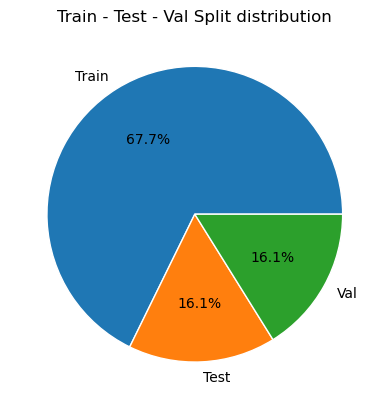

In [53]:
x = [len(dataset["almonds"]["train_ids"]), len(dataset["almonds"]["test_ids"]), len(dataset["almonds"]["val_ids"])]
plt.pie(x, labels=["Train", "Test", "Val"], autopct="%1.1f%%", wedgeprops=dict(edgecolor="w"))
plt.title("Train - Test - Val Split distribution")
plt.show()

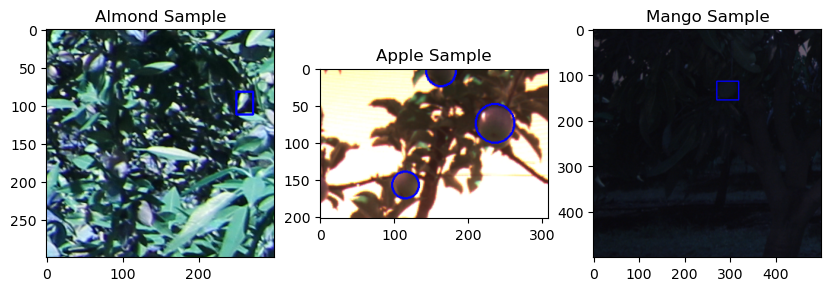

In [56]:
import cv2
almond_sample = pd.Series(dataset["almonds"]["global_df"].picture_id.unique()).sample(1)
apple_sample = pd.Series(dataset["apples"]["global_df"].picture_id.unique()).sample(1)
mangoes_sample = pd.Series(dataset["mangoes"]["global_df"].picture_id.unique()).sample(1)
almond_sample = dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id == almond_sample.item()]
apple_sample = dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id == apple_sample.item()]
mangoes_sample = dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id == mangoes_sample.item()]

# draw ROI on random almond sample
almond_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/almonds/images", f"{almond_sample.picture_id.iloc[0]}.png"))
almond_sample.reset_index(inplace=True, drop=True)
for idx, row in almond_sample.iterrows():
    cv2.rectangle(almond_sample_img, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(0,0,255), thickness=2)

# draw ROI on random apple sample
apple_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/apples/images", f"{apple_sample.picture_id.iloc[0]}.png"))
apple_sample.reset_index(inplace=True, drop=True)
for idx, row in apple_sample.iterrows():
    cv2.circle(apple_sample_img, (int(row["c-x"]), int(row["c-y"])), int(row.radius), color=(0,0,255), thickness=2)

# draw ROI on random mango example
mangoes_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/mangoes/images", f"{mangoes_sample.picture_id.iloc[0]}.png"))
mangoes_sample.reset_index(inplace=True, drop=True)
for idx, row in mangoes_sample.iterrows():
    cv2.rectangle(mangoes_sample_img, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(0,0,255), thickness=2)


fig, ax = plt.subplots(1,3, figsize=(10,8))
ax[0].imshow(almond_sample_img)
ax[0].set_title("Almond Sample")
ax[1].imshow(apple_sample_img)
ax[1].set_title("Apple Sample")
ax[2].imshow(mangoes_sample_img)
ax[2].set_title("Mango Sample")
plt.show()

In [57]:
from tqdm import tqdm
import os
import pandas as pd
import cv2
apple_shapes = {
    "x": list(),
    "y": list(),
    "pixels": list(),
    "mean": list(),
    "picture_id": list()
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/apples/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/apples/images", picture_name))
    apple_shapes["x"].append(pic.shape[1])
    apple_shapes["y"].append(pic.shape[0])
    apple_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    apple_shapes["picture_id"].append(picture_name[:-4])
    apple_shapes["mean"].append(pic.mean())
apple_shapes = pd.DataFrame(apple_shapes)

mango_shapes = {
    "x": list(),
    "y": list(),
    "pixels": list(),
    "mean": list(),
    "picture_id": list()
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/mangoes/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/mangoes/images", picture_name))
    mango_shapes["x"].append(pic.shape[1])
    mango_shapes["y"].append(pic.shape[0])
    mango_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    mango_shapes["picture_id"].append(picture_name[:-4])
    mango_shapes["mean"].append(pic.mean())
mango_shapes = pd.DataFrame(mango_shapes)

almond_shapes = {
    "x": list(),
    "y": list(),
    "pixels": list(),
    "mean": list(),
    "picture_id": list()
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/almonds/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/almonds/images", picture_name))
    almond_shapes["x"].append(pic.shape[1])
    almond_shapes["y"].append(pic.shape[0])
    almond_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    almond_shapes["picture_id"].append(picture_name[:-4])
    almond_shapes["mean"].append(pic.mean())
almond_shapes = pd.DataFrame(almond_shapes)

apple_shapes

100%|██████████████████████████████████████████████████████████████████| 620/620 [00:02<00:00, 213.45it/s]


,x,y,pixels,mean,picture_id
0,308,202,62216,97.444896,20130320T004615.614293.Cam6_51
1,308,202,62216,184.350623,20130320T013657.200420_21
2,308,202,62216,97.161363,20130320T013024.621036_62
3,308,202,62216,139.973153,20130320T004807.235605.Cam6_22
4,308,202,62216,212.991605,20130320T005104.572657.Cam6_14
...,...,...,...,...,...
1115,308,202,62216,166.783914,20130320T005423.814872.Cam6_12
1116,308,202,62216,112.020059,20130320T013321.386510_31
1117,308,202,62216,52.170096,20130320T005816.391049.Cam6_51
1118,308,202,62216,118.021908,20130320T005239.812601.Cam6_34


In [58]:
variances = pd.DataFrame()
variances["apple_shapes"] = apple_shapes.var(numeric_only=True)
variances["almond_shapes"] = almond_shapes.var(numeric_only=True)
variances["mango_shapes"] = mango_shapes.var(numeric_only=True)
variances

,apple_shapes,almond_shapes,mango_shapes
x,0.000000,0.000000,0.000000
y,0.000000,0.000000,0.000000
pixels,0.000000,0.000000,0.000000
mean,2461.866215,1128.139201,198.633097


In [59]:
mango_shapes.x.unique(), mango_shapes.y.unique(), mango_shapes.pixels.unique() # Variance above comes from a library bottleneck, that pandas uses for faster calculation -> Numeric precision leads to rounding errors

(array([500]), array([500]), array([250000]))

Text(0.5, 1.0, 'Image Brightness')

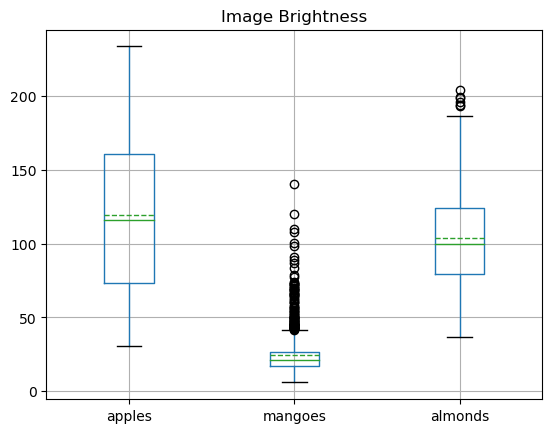

In [60]:
means = pd.DataFrame()
means["apples"] = apple_shapes["mean"]
means["mangoes"] = mango_shapes["mean"]
means["almonds"] = almond_shapes["mean"]
means.boxplot(showmeans=True, meanline=True)
plt.title("Image Brightness")

## Converting to Coco Format

In [61]:
categories_almond = [{
    "id": 0,
    "name": "almond",
    "supercategory": "fruit"
}]
categories_apple = [{
    "id": 0,
    "name": "apple",
    "supercategory": "fruit"
}]
categories_mangoes = [{
    "id": 0,
    "name": "mango",
    "supercategory": "fruit"
}]
categories_all = [
    {
        "id": 0,
        "name": "almond",
        "supercategory": "fruit"
    },
    {
        "id": 1,
        "name": "apple",
        "supercategory": "fruit"
    },
    {
        "id": 2,
        "name": "mango",
        "supercategory": "fruit"
    }
]

In [62]:
from typing import Dict, List, Union
def image_shapes_to_coco(shapes: pd.DataFrame) -> List[Dict[str, Union[int,str,None]]]:
        shapes = shapes.copy()
        shapes["id"] = shapes.index
        shapes.rename(columns={
            "x": "width",
            "y": "height",
            "picture_id": "file_name"
        }, inplace=True)
        shapes["license"] = None
        shapes["date_captured"] = None
        shapes.file_name = shapes.file_name.astype(str)
        shapes.file_name = shapes.file_name.str.cat([".png" for _ in range(len(shapes.file_name))])
        shapes.drop(columns=["mean", "pixels"], inplace=True)
        return shapes.to_dict(orient="record")

In [63]:
image_shapes_to_coco(shapes=apple_shapes)

/tmp/ipykernel_14248/2568751409.py:15: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  return shapes.to_dict(orient="record")


[{'width': 308,
  'height': 202,
  'file_name': '20130320T004615.614293.Cam6_51.png',
  'id': 0,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T013657.200420_21.png',
  'id': 1,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T013024.621036_62.png',
  'id': 2,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T004807.235605.Cam6_22.png',
  'id': 3,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T005104.572657.Cam6_14.png',
  'id': 4,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T005323.051613.Cam6_21.png',
  'id': 5,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T004808.188000.Cam6_61.png',
  'id': 6,
  'license': None,
  'date_captured': None},
 {'width': 308,


In [65]:
import swifter
def annotations_to_coco(annotations: pd.DataFrame, shapes: pd.DataFrame, apples=False) -> List[Dict[str, Union[int, List[int]]]]:
    annotations = annotations.copy()
    shapes = shapes.copy()
    shapes["image_id"] = shapes.index
    annotations["id"] = annotations.index
    annotations["picture_id"] = annotations.picture_id.astype(str)
    annotations = pd.merge(left=annotations, right=shapes[["picture_id", "image_id"]], how="left", on="picture_id")
    annotations["category_id"] = [1 for _ in range(len(annotations))]
    if apples:
        annotations["bbox"] = annotations.swifter.apply(lambda row: [int(row["c-x"]-row["radius"]), int(row["c-y"]-row["radius"]), int(2*row.radius), int(2*row.radius)], axis=1)
        annotations["area"] = 2*annotations.radius * 2*annotations.radius
        annotations.drop(columns=["picture_id", "#item", "label", "c-x", "c-y", "radius"], inplace=True)
    else:
        annotations["bbox"] = annotations.swifter.apply(lambda row: [int(row.x), int(row.y), int(row.dx), int(row.dy)], axis=1)
        annotations["area"] = annotations.dx * annotations.dy
        annotations.drop(columns=["picture_id", "#item", "label", "x", "y", "dx", "dy"], inplace=True)
    annotations["iscrowd"] = 0
    annotations["iscrowd"] = 0
    return annotations.to_dict(orient="record")

In [66]:
annotations_to_coco(annotations=dataset['almonds']['global_df'], shapes=almond_shapes)

Pandas Apply:   0%|          | 0/4777 [00:00<?, ?it/s]

[{'id': 0,
  'image_id': 355,
  'category_id': 1,
  'bbox': [18, 37, 28, 32],
  'area': 896.0,
  'iscrowd': 0},
 {'id': 1,
  'image_id': 355,
  'category_id': 1,
  'bbox': [20, 20, 30, 34],
  'area': 1020.0,
  'iscrowd': 0},
 {'id': 2,
  'image_id': 355,
  'category_id': 1,
  'bbox': [0, 59, 34, 32],
  'area': 1088.0,
  'iscrowd': 0},
 {'id': 3,
  'image_id': 355,
  'category_id': 1,
  'bbox': [1, 264, 30, 32],
  'area': 960.0,
  'iscrowd': 0},
 {'id': 4,
  'image_id': 45,
  'category_id': 1,
  'bbox': [2, 105, 18, 26],
  'area': 468.0,
  'iscrowd': 0},
 {'id': 5,
  'image_id': 45,
  'category_id': 1,
  'bbox': [15, 111, 18, 26],
  'area': 468.0,
  'iscrowd': 0},
 {'id': 6,
  'image_id': 45,
  'category_id': 1,
  'bbox': [40, 111, 18, 22],
  'area': 396.0,
  'iscrowd': 0},
 {'id': 7,
  'image_id': 45,
  'category_id': 1,
  'bbox': [43, 89, 26, 26],
  'area': 676.0,
  'iscrowd': 0},
 {'id': 8,
  'image_id': 45,
  'category_id': 1,
  'bbox': [79, 51, 26, 26],
  'area': 676.0,
  'iscrowd'

In [67]:
apple_coco_train = {
    "categories": categories_apple,
    "images": image_shapes_to_coco(apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))], apples=True),
    "licenses": None,
    "info": None
}
apple_coco_test = {
    "categories": categories_apple,
    "images": image_shapes_to_coco(apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))], apples=True),
    "licenses": None,
    "info": None
}
apple_coco_val = {
    "categories": categories_apple,
    "images": image_shapes_to_coco(apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))], apples=True),
    "licenses": None,
    "info": None
}
almonds_coco_train = {
    "categories": categories_almond,
    "images": image_shapes_to_coco(almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
almonds_coco_test = {
    "categories": categories_almond,
    "images": image_shapes_to_coco(almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
almonds_coco_val = {
    "categories": categories_almond,
    "images": image_shapes_to_coco(almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
mangoes_coco_train = {
    "categories": categories_mangoes,
    "images": image_shapes_to_coco(mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
mangoes_coco_test = {
    "categories": categories_mangoes,
    "images": image_shapes_to_coco(mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
mangoes_coco_val = {
    "categories": categories_mangoes,
    "images": image_shapes_to_coco(mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}

Pandas Apply:   0%|          | 0/4673 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/554 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/538 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3185 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/797 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/795 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5186 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/947 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/932 [00:00<?, ?it/s]

In [68]:
from shutil import copy
import json

def create_coco_dir_struct(label_json_train: dict, label_json_test: dict, label_json_val: dict, fruit: str):
    # automatically create dirs if not exist
    os.makedirs(name=f"datasets/acfr-fruit-dataset/{fruit}/coco/train", exist_ok=True)
    os.makedirs(name=f"datasets/acfr-fruit-dataset/{fruit}/coco/test", exist_ok=True)
    os.makedirs(name=f"datasets/acfr-fruit-dataset/{fruit}/coco/val", exist_ok=True)

    for image_struct in label_json_train["images"]:
        copy(src=f"datasets/acfr-fruit-dataset/{fruit}/images/{image_struct['file_name']}", dst=f"datasets/acfr-fruit-dataset/{fruit}/coco/train/")
    for image_struct in label_json_test["images"]:
        copy(src=f"datasets/acfr-fruit-dataset/{fruit}/images/{image_struct['file_name']}", dst=f"datasets/acfr-fruit-dataset/{fruit}/coco/test/")
    for image_struct in label_json_val["images"]:
        copy(src=f"datasets/acfr-fruit-dataset/{fruit}/images/{image_struct['file_name']}", dst=f"datasets/acfr-fruit-dataset/{fruit}/coco/val/")

    open(f"datasets/acfr-fruit-dataset/{fruit}/coco/train.json", "w+").write(json.dumps(label_json_train))
    open(f"datasets/acfr-fruit-dataset/{fruit}/coco/test.json", "w+").write(json.dumps(label_json_test))
    open(f"datasets/acfr-fruit-dataset/{fruit}/coco/val.json", "w+").write(json.dumps(label_json_val))

In [69]:
label_jsons = {
    "almonds": [almonds_coco_train, almonds_coco_val, almonds_coco_test],
    "apples": [apple_coco_train, apple_coco_val, apple_coco_test],
    "mangoes": [mangoes_coco_train, mangoes_coco_val, mangoes_coco_test],
}
# Create Directories
for fruit, labels in label_jsons.items():
    create_coco_dir_struct(label_json_train=labels[0], label_json_test=labels[2], label_json_val=labels[1], fruit=fruit)

## Pytorch Dataloader & Dataset

In [1]:
import torchvision

class CocoDetection(torchvision.datasets.CocoDetection):

    def __init__(self, img_folder, feature_extractor, train=True):
        annotations_path = os.path.join(img_folder, "../train.json" if train else "../val.json")
        super(CocoDetection, self).__init__(img_folder, annotations_path)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read image and target
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (resizing + normalization)
        image_id = self.ids[idx]
        target = {"image_id": image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0]

        return pixel_values, target

In [2]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch

## Models

- Baseline: Faster R-CNN (Dataset Paper)
- YOLOS: You Only Look at One Sequence: Vision Transformer inspired by YOLO
- DETR: Vision Transformer with a Convolutional Backbone

## YOLOS

In [6]:
!pip install pycocotools

  Using cached pycocotools-2.0.6.tar.gz (24 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp39-cp39-linux_x86_64.whl size=104434 sha256=9d040906aae0a35229268c0e629cf412b870d41e2c37206760ffd0004147bb76
  Stored in directory: /home/ubuntu/.cache/pip/wheels/29/98/97/6c7dca1f8e4c854e15a2676ac98ae3f46ec83ee031d827a5c8
Successfully built pycocotools


In [3]:
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:710: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [4]:
batch = next(iter(train_dataloader))
print(batch.keys())
pixel, target = train_dataset[2]
print("pixel shape", pixel.shape)
print(target)

dict_keys(['pixel_values', 'labels'])
pixel shape torch.Size([3, 512, 780])
{'size': tensor([512, 780]), 'image_id': tensor([2]), 'class_labels': tensor([1, 1]), 'boxes': tensor([[0.2646, 0.1559, 0.1201, 0.1832],
        [0.4026, 0.1782, 0.1494, 0.2277]]), 'area': tensor([ 8978.5391, 13748.3057]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([202, 308])}


/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:824: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [37]:
import pytorch_lightning as pl
from transformers import AutoModelForObjectDetection
import torch

class Yolos(pl.LightningModule):

    def __init__(self, lr, weight_decay, trained="hustvl/yolos-small"):
        super().__init__()
        self.model = AutoModelForObjectDetection.from_pretrained(trained,
                                                             num_labels=1,
                                                             ignore_mismatched_sizes=True)
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values):
        return self.model(pixel_values=pixel_values)

    def common_step(self, batch):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, labels=labels)
        return outputs.loss, outputs.loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [39]:
model = Yolos(lr=2.5e-5, weight_decay=1e-4)
outputs = model(pixel_values=batch['pixel_values'])
outputs.logits.shape

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 100, 2])

In [7]:
from pytorch_lightning import Trainer
torch.device("cuda")
trainer = Trainer(max_steps=2000, gradient_clip_val=0.1, accumulate_grad_batches=4, log_every_n_steps=10)
trainer.fit(model=model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.600   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:824: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-pack

Training: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [11]:
torch.save(model.state_dict(), "models/yolos_apples_v8.pt")

In [40]:
model.load_state_dict(torch.load("models/yolos_apples_v8.pt"))

<All keys matched successfully>

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Detected apple with confidence 0.255 at location [43.91, 5.42, 74.54, 28.43]
Detected apple with confidence 0.33 at location [6.69, 40.02, 55.4, 83.65]
Detected apple with confidence 0.522 at location [8.38, 116.76, 69.73, 159.5]
Detected apple with confidence 0.333 at location [143.23, 63.55, 207.61, 114.85]
Detected apple with confidence 0.407 at location [224.62, 159.46, 269.48, 200.47]
Detected apple with confidence 0.413 at location [85.93, 35.96, 126.36, 70.48]
Detected apple with confidence 0.968 at location [75.08, 43.04, 129.38, 95.56]
Detected apple with confidence 0.544 at location [155.39, 47.87, 209.03, 85.26]
Detected apple with confidence 0.931 at location [47.61, 78.47, 90.51, 115.98]
Detected apple with confidence 0.37 at location [110.45, 82.88, 150.5, 107.38]
Detected apple with confidence 0.346 at location [197.91, 56.32, 237.25, 85.79]
Detected apple with confidence 0.229 at location [233.4, -0.04, 291.49, 25.66]
Detected apple with confidence 0.298 at location [10

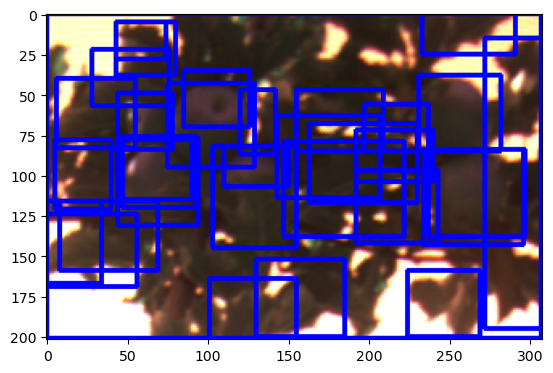

In [35]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
import cv2

image = Image.open(os.path.join("datasets/acfr-fruit-dataset/apples/coco/val",
                                val_dataset.coco.loadImgs(
                                    val_dataset[
                                        np.random.randint(0, len(val_dataset))
                                    ][1]["image_id"].item())
                                [0]['file_name']
                                )
                   )

image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {model.config.id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)
plt.imshow(image)

## DETR

In [ ]:
from transformers import AutoImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
import cv2
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {model.config.id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)
plt.imshow(image)

## Evaluation

In [41]:
from coco_eval import CocoEvaluator, get_coco_api_from_dataset
from tqdm.notebook import tqdm

base_ds = get_coco_api_from_dataset(val_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/112 [00:00<?, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:1167: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95

## Conclusion